## Plotting the results of hyperparameter scans

This notebook depends on `wcpred_hyperparameter_scan` having been run, and populating a directory (say "../output") with .txt files containing loss function values for different sets of hyperparameter values.

The "loss function" is defined as the sum over all teams in a tournament of how far each team got vs how far we predicted it to get.  i.e. if a team goes out at the group stage, but we predicted it would get to the quarter final, that would contribute *2* to the loss function.  For each set of hyperparameters, we run the tournament many times, and take the mean of the loss function for the purpose of the plots below.

We will plot loss vs years-of-training-data, for some of these sets, in particular, looking to answer two questions:
* Should we exclude friendlies from our training data?
* What should we use for covariate priors?  Nothing, or rankings from the FIFA videogame (with default values chosen for teams not featured), or the official FIFA rankings.

In [68]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [69]:
def get_loss_value(filename):
    losses = np.fromfile(filename, dtype=int, sep='\n')
    meanloss = losses.mean()
    return meanloss

Read all the values from all the text files into a single dataframe

In [70]:
def get_all_losses(input_dir):
    filenames = os.listdir(input_dir)
    filenames = [f for f in filenames if "_loss.txt" in f]
    filename_regex = re.compile("([\d]{4})_([\d]+)_([\w]+)_([\w]+_[\w]+)_loss.txt")
    vals = {"tournament": [], "num_years": [], "ratings_src": [], "competitions": [], "loss": []}
    for filename in filenames:
        matches = filename_regex.search(filename)
        if not matches:
            continue
        tournament, num_years, ratings, comps = matches.groups()
        loss = get_loss_value(os.path.join(input_dir, filename))
        vals["tournament"].append(tournament)
        vals["num_years"].append(int(num_years))
        vals["ratings_src"].append(ratings)
        vals["competitions"].append(comps)
        vals["loss"].append(loss)
    df = pd.DataFrame(vals)
    df =df.sort_values("num_years")
    return df

In [71]:
df=get_all_losses("../output")

Extract things from the dataframe into lists, ready for matplotlib.   Slightly clunky!

In [80]:
def get_plot_values(df, tournament, xvar, yval_const, yval_options):
    """
    return a tuple of lists.
    
    parameters
    ----------
    df: pandas DataFrame
    tournament: str, can be "2014" or "2018"
    xvar: str, variable for the x-axis, normaly "num_years"
    yval_const: tuple (variable_name, value)
    yval_options: tuple (variable_name, [value1, value2,...])
    
    returns
    -------
    xvals (list of ints) , yvals (list of tuple(str, list))
    """
    xvals = list(df.num_years.unique())
    df = df[df.tournament==tournament]
    df = df[df[yval_const[0]]==yval_const[1]]
    yvals = []
    for option in yval_options[1]:
        vals = list(df[df[yval_options[0]]==option].loss.values)
        yvals.append((option, vals))
    return xvals, yvals

### Exclude friendlies?

Set the covariate priors source fixed to "game" (i.e. using rankings from FIFA videogame), and look at whether we do better (lower loss function values) if we exclude friendlies from the training data or not.

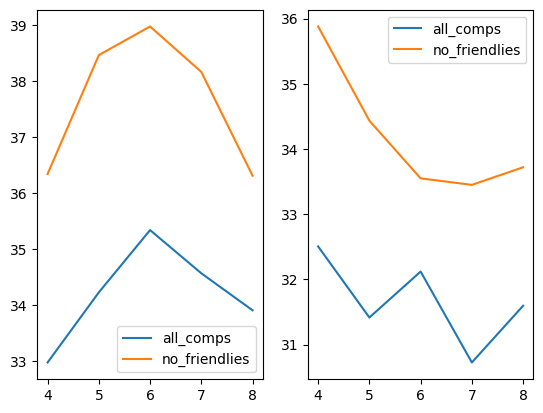

In [81]:
fix, ax = plt.subplots(1,2)
for i, tourn in enumerate(["2014","2018"]):
    xvals, yvals = get_plot_values(df, tourn,"num_years", ("ratings_src","game"), ("competitions",["all_comps","no_friendlies"]))
    for option in yvals:
        ax[i].plot(xvals, option[1], label=option[0])
    ax[i].legend()


So, we do significantly better by including friendlies.

### Ratings source
Should we use FIFA videogame, FIFA organisation rankings, or nothing?

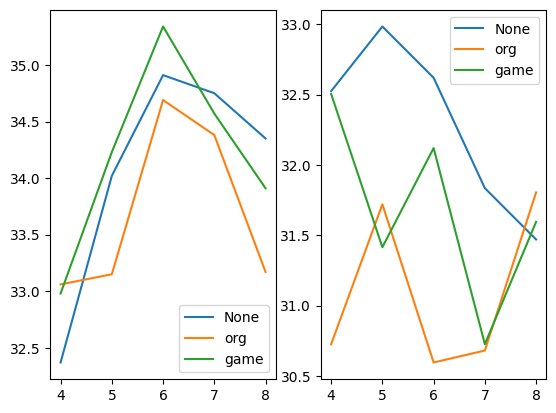

In [83]:
fix, ax = plt.subplots(1,2)
for i, tourn in enumerate(["2014","2018"]):
    xvals, yvals = get_plot_values(df, tourn,"num_years", ("competitions","all_comps"), ("ratings_src",["None","org","game"]))
    for option in yvals:
        ax[i].plot(xvals, option[1], label=option[0])
    ax[i].legend()

Hmm..... unclear!!!